
# MolDiff: Complete 3D Molecular Generation Tutorial

This notebook demonstrates a complete implementation of MolDiff - a diffusion model for 3D molecular generation that addresses the atom-bond inconsistency problem.

## Key Improvements Over Basic Implementations

1. **Joint Atom-Bond Modeling**: Explicit bond prediction alongside atoms and positions
2. **Categorical Diffusion**: Proper handling of discrete features (atom types, bond types)
3. **Bond-Aware Message Passing**: GNN that considers both atoms and bonds
4. **Chemical Validity**: Constraints and guidance for realistic molecules
5. **Different Noise Schedules**: Bonds diffuse faster than atoms (key MolDiff insight)

---

In [1]:
import torch
import torch.nn.functional as F
from torch.optim import AdamW
import logging
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem

# Import all improved components
from mol_diff_3d.data.datasets import ImprovedQm9MolecularDataset
from mol_diff_3d.models.diffusion import MolecularDiffusionModel, BondPredictor
from mol_diff_3d.models.noise_scheduler import NoiseScheduler
from mol_diff_3d.sampling.samplers import ImprovedDDPMQSampler, ImprovedDDPMPsampler
from mol_diff_3d.training.trainer import ImprovedDDPMTrainer
# from mol_diff_3d.models.categorical_diffusion import CategoricalNoiseScheduler, CategoricalDiffusion
from mol_diff_3d.models.transitions import GeneralCategoricalTransition, get_beta_schedule
from mol_diff_3d.generation.generator import generate_molecules_with_bond_guidance
from mol_diff_3d.utils.checkpoints import save_checkpoint, load_checkpoint

# Set up logging and visualization
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Setup matplotlib for notebook
%matplotlib inline
plt.style.use('default')


No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'dgl'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/home/jantine/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning depende

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Complete configuration for MolDiff training
config = {
    # Data Configuration
    'max_atoms': 25,              # Maximum atoms per molecule
    'max_samples': 10000,         # Number of training samples (increase for better results)
    'batch_size': 32,             # Batch size for training

    # Model Architecture
    'atom_dim': 15,               # Expanded atom feature dimension (10 elements + 5 properties)
    'bond_dim': 7,                # Bond feature dimension (5 types + 2 properties)
    'pos_dim': 3,                 # 3D coordinates
    'hidden_dim': 128,            # Hidden dimension for GNN
    'time_dim': 10,              # Time embedding dimension
    'num_gnn_layers': 6,          # Number of E3GNN layers

    # Training Configuration
    'num_timesteps': 1000,        # Diffusion timesteps
    'learning_rate': 1e-4,        # Learning rate (slightly higher for joint training)
    'epochs': 200,                # Training epochs (more needed for complex model)
    'log_interval': 10,           # Logging frequency

    # Loss Weights (Critical for good results)
    'atom_loss_weight': 1.0,      # Atom type prediction loss weight
    'pos_loss_weight': 1.0,       # Position prediction loss weight
    'bond_loss_weight': 2.0,      # Bond prediction loss weight (higher - bonds are crucial!)
    'guidance_loss_weight': 0.5,  # Bond predictor guidance loss weight

    # Generation Configuration
    'num_molecules_to_generate': 20,
    'guidance_steps': 200,        # Number of timesteps to apply bond guidance
    'temperature': 0.7,           # Sampling temperature
}

In [4]:
results_dir = Path("../results/moldiff_improved")  # This will be experiments/results/moldiff_improved
results_dir.mkdir(parents=True, exist_ok=True)

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  max_atoms: 25
  max_samples: 10000
  batch_size: 32
  atom_dim: 15
  bond_dim: 7
  pos_dim: 3
  hidden_dim: 128
  time_dim: 128
  num_gnn_layers: 4
  num_timesteps: 1000
  learning_rate: 0.0005
  epochs: 200
  log_interval: 10
  atom_loss_weight: 1.0
  pos_loss_weight: 1.0
  bond_loss_weight: 2.0
  guidance_loss_weight: 0.5
  num_molecules_to_generate: 20
  guidance_steps: 200
  temperature: 0.7


In [5]:
# Data Preparation

print("="*50)
print("STEP 1: DATA PREPARATION")
print("="*50)

# Load improved dataset with explicit bond features
dataset = ImprovedQm9MolecularDataset(max_atoms=config['max_atoms'])
info = dataset.get_dataset_info()

print("\nDataset Information:")
for key, value in info.items():
    print(f"  {key}: {value}")

# Create dataloader with bond features
dataloader = dataset.create_dataloader(
    batch_size=config['batch_size'],
    shuffle=True,
    max_samples=config['max_samples']
)

# Inspect sample batch to verify bond features are included
sample_batch = next(iter(dataloader))
print(f"\nSample Batch Verification:")
print(f"  Number of molecules: {sample_batch.num_graphs}")
print(f"  Atom features shape: {sample_batch.x.shape}")
print(f"  Bond features shape: {sample_batch.edge_attr.shape}")  # This should exist now!
print(f"  Positions shape: {sample_batch.pos.shape}")
print(f"  Edge index shape: {sample_batch.edge_index.shape}")

# Verify bond feature distribution
bond_types = sample_batch.edge_attr.argmax(dim=1)
print(f"  Bond type distribution in sample: {torch.bincount(bond_types)}")


INFO:mol_diff_3d.data.datasets:Loading DeepChem dataset: QM9


STEP 1: DATA PREPARATION


INFO:deepchem.molnet.load_function.molnet_loader:About to featurize qm9 dataset.
INFO:deepchem.data.data_loader:Loading raw samples now.
INFO:deepchem.data.data_loader:shard_size: 4096
INFO:deepchem.utils.data_utils:Reading structures from /tmp/gdb9.sdf.
[14:52:20] Explicit valence for atom # 1 C, 5, is greater than permitted
[14:52:20] ERROR: Could not sanitize molecule ending on line 2704
[14:52:20] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[14:52:20] Explicit valence for atom # 1 C, 5, is greater than permitted
[14:52:20] ERROR: Could not sanitize molecule ending on line 9097
[14:52:20] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[14:52:20] Explicit valence for atom # 2 C, 5, is greater than permitted
[14:52:20] ERROR: Could not sanitize molecule ending on line 19803
[14:52:20] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[14:52:20] Explicit valence for atom # 2 C, 5, is greater than permitted
[14:52:20] ERR


Dataset Information:
  name: qm9_with_bonds
  size: 105576
  max_atoms: 25
  atom_feature_dim: 15
  bond_feature_dim: 7
  num_atom_types: 10
  num_bond_types: 5


INFO:mol_diff_3d.data.datasets:Processed 1000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Processed 2000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Processed 3000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Processed 4000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Processed 5000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Processed 6000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Processed 7000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Processed 8000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Processed 9000/10000 molecules...
INFO:mol_diff_3d.data.datasets:Successfully converted 9960/10000 molecules (99.6%)
INFO:mol_diff_3d.data.datasets:Failed conversions: 40
INFO:mol_diff_3d.data.datasets:Dataset statistics:
INFO:mol_diff_3d.data.datasets:  Average atoms per molecule: 18.0
INFO:mol_diff_3d.data.datasets:  Average bonds per molecule: 18.6
INFO:mol_diff_3d.data.datasets:  Max atoms: 25
INFO:mol_diff_3d.data.datasets:  Max bonds: 26
I


Sample Batch Verification:
  Number of molecules: 32
  Atom features shape: torch.Size([558, 15])
  Bond features shape: torch.Size([9534, 7])
  Positions shape: torch.Size([558, 3])
  Edge index shape: torch.Size([2, 9534])
  Bond type distribution in sample: tensor([8394, 1014,   48,   18,   60])


/home/jantine/miniconda3/envs/diff_gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
print("="*50)
print("STEP 2: MODEL INITIALIZATION")
print("="*50)

# 1. Main diffusion model with joint atom-bond-position modeling
model = MolecularDiffusionModel(
    atom_dim=info['atom_feature_dim'],
    bond_dim=info['bond_feature_dim'],
    pos_dim=config['pos_dim'],
    hidden_dim=config['hidden_dim'],
    time_dim=config['time_dim'],
    num_gnn_layers=config['num_gnn_layers'],
    max_atoms=config['max_atoms']
).to(device)

# 2. Bond predictor for guidance (NEW - helps with chemical validity)
bond_predictor = BondPredictor(
    atom_dim=info['atom_feature_dim'],
    pos_dim=config['pos_dim'],
    hidden_dim=config['hidden_dim']
).to(device)

# 3. Noise schedulers
# Continuous scheduler for positions (standard)
continuous_scheduler = NoiseScheduler(
    num_timesteps=config['num_timesteps']
).to(device)


# Create MolDiff beta schedules
node_betas = get_beta_schedule(
    beta_schedule='advance',
    num_timesteps=config['num_timesteps'],
    scale_start=0.9999,
    scale_end=0.0001,
    width=3
)

bond_betas = get_beta_schedule(
    beta_schedule='segment',
    num_timesteps=config['num_timesteps'],
    time_segment=[600, 400],
    segment_diff=[
        {'scale_start': 0.9999, 'scale_end': 0.001, 'width': 3},
        {'scale_start': 0.001, 'scale_end': 0.0001, 'width': 2}
    ]
)

# Create MolDiff transitions
atom_transition = GeneralCategoricalTransition(
    betas=node_betas,
    num_classes=10,
    init_prob='tomask'
)

bond_transition = GeneralCategoricalTransition(
    betas=bond_betas,
    num_classes=5,
    init_prob='absorb'
)


# 5. Samplers
q_sampler = ImprovedDDPMQSampler(
    continuous_scheduler.get_parameters(),
    atom_transition,
    bond_transition
)

# 6. Optimizer with different learning rates for different components
optimizer = torch.optim.AdamW([
    {'params': model.parameters(),
     'lr': 1e-4, 'weight_decay': 1e-8, 'betas': (0.99, 0.999)},
    {'params': bond_predictor.parameters(),
     'lr': 5e-5, 'weight_decay': 1e-8, 'betas': (0.99, 0.999)}
])

# Print model information
total_params = sum(p.numel() for p in model.parameters())
bond_params = sum(p.numel() for p in bond_predictor.parameters())
print(f"\nModel Architecture:")
print(f"  Main model parameters: {total_params:,}")
print(f"  Bond predictor parameters: {bond_params:,}")
print(f"  Total parameters: {total_params + bond_params:,}")

STEP 2: MODEL INITIALIZATION

Model Architecture:
  Main model parameters: 663,721
  Bond predictor parameters: 52,999
  Total parameters: 716,720


In [7]:
print("="*50)
print("STEP 3: TRAINING SETUP")
print("="*50)

# Initialize improved trainer with joint loss function
trainer = ImprovedDDPMTrainer(
    model=model,
    bond_predictor=bond_predictor,
    q_sampler=q_sampler,
    atom_transition = atom_transition,
    bond_transition = bond_transition,
    optimizer=optimizer,
    device=device,
    config=config
)

print("Trainer Configuration:")
print(f"  Atom loss weight: {config['atom_loss_weight']}")
print(f"  Position loss weight: {config['pos_loss_weight']}")
print(f"  Bond loss weight: {config['bond_loss_weight']}")  # Higher weight for bonds!
print(f"  Guidance loss weight: {config['guidance_loss_weight']}")
print(f"  Training epochs: {config['epochs']}")
print(f"  Learning rate: {config['learning_rate']}")

STEP 3: TRAINING SETUP
Trainer Configuration:
  Atom loss weight: 1.0
  Position loss weight: 1.0
  Bond loss weight: 2.0
  Guidance loss weight: 0.5
  Training epochs: 200
  Learning rate: 0.0005


In [8]:
print("="*50)
print("STEP 4: JOINT TRAINING")
print("="*50)

# Train the models with joint atom-bond-position loss
print("Starting improved joint training...")
print("This will take significant time - monitor the loss components!")

losses, detailed_losses = trainer.train(dataloader, num_epochs=config['epochs'])

print(f"\nTraining completed!")
print(f"Final total loss: {losses[-1]:.4f}")
print(f"Final atom loss: {detailed_losses['atom'][-1]:.4f}")
print(f"Final position loss: {detailed_losses['pos'][-1]:.4f}")
print(f"Final bond loss: {detailed_losses['bond'][-1]:.4f}")
if detailed_losses['guidance']:
    print(f"Final guidance loss: {detailed_losses['guidance'][-1]:.4f}")

STEP 4: JOINT TRAINING
Starting improved joint training...
This will take significant time - monitor the loss components!
Starting joint atom-bond-position training on cuda
Model parameters: 663,721
Bond predictor parameters: 52,999


Epoch 0: 100%|██████████| 312/312 [00:11<00:00, 28.09it/s]


Epoch [0/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.3356


Epoch 10: 100%|██████████| 312/312 [00:10<00:00, 29.83it/s]


Epoch [10/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0022


Epoch 20: 100%|██████████| 312/312 [00:09<00:00, 31.80it/s]


Epoch [20/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0005


Epoch 30: 100%|██████████| 312/312 [00:10<00:00, 28.88it/s]


Epoch [30/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0003


Epoch 40: 100%|██████████| 312/312 [00:09<00:00, 33.11it/s]


Epoch [40/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0003


Epoch 50: 100%|██████████| 312/312 [00:09<00:00, 34.54it/s]


Epoch [50/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0003


Epoch 60: 100%|██████████| 312/312 [00:10<00:00, 28.82it/s]


Epoch [60/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 70: 100%|██████████| 312/312 [00:11<00:00, 28.30it/s]


Epoch [70/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 80: 100%|██████████| 312/312 [00:10<00:00, 29.44it/s]


Epoch [80/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0003


Epoch 90: 100%|██████████| 312/312 [00:09<00:00, 33.51it/s]


Epoch [90/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0003


Epoch 100: 100%|██████████| 312/312 [00:10<00:00, 30.46it/s]


Epoch [100/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 110: 100%|██████████| 312/312 [00:09<00:00, 33.96it/s]


Epoch [110/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 120: 100%|██████████| 312/312 [00:09<00:00, 32.59it/s]


Epoch [120/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 130: 100%|██████████| 312/312 [00:10<00:00, 28.55it/s]


Epoch [130/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 140: 100%|██████████| 312/312 [00:09<00:00, 31.96it/s]


Epoch [140/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 150: 100%|██████████| 312/312 [00:10<00:00, 30.02it/s]


Epoch [150/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 160: 100%|██████████| 312/312 [00:10<00:00, 29.39it/s]


Epoch [160/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 170: 100%|██████████| 312/312 [00:10<00:00, 28.78it/s]


Epoch [170/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 180: 100%|██████████| 312/312 [00:11<00:00, 28.29it/s]


Epoch [180/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 190: 100%|██████████| 312/312 [00:10<00:00, 29.26it/s]


Epoch [190/200]:
  Total Loss: nan
  Atom Loss: nan
  Position Loss: nan
  Bond Loss: nan
  Guidance Loss: 0.0002


Epoch 199: 100%|██████████| 312/312 [00:10<00:00, 29.33it/s]

Joint training completed!

Training completed!
Final total loss: nan
Final atom loss: nan
Final position loss: nan
Final bond loss: nan
Final guidance loss: 0.0002


STEP 5: TRAINING ANALYSIS


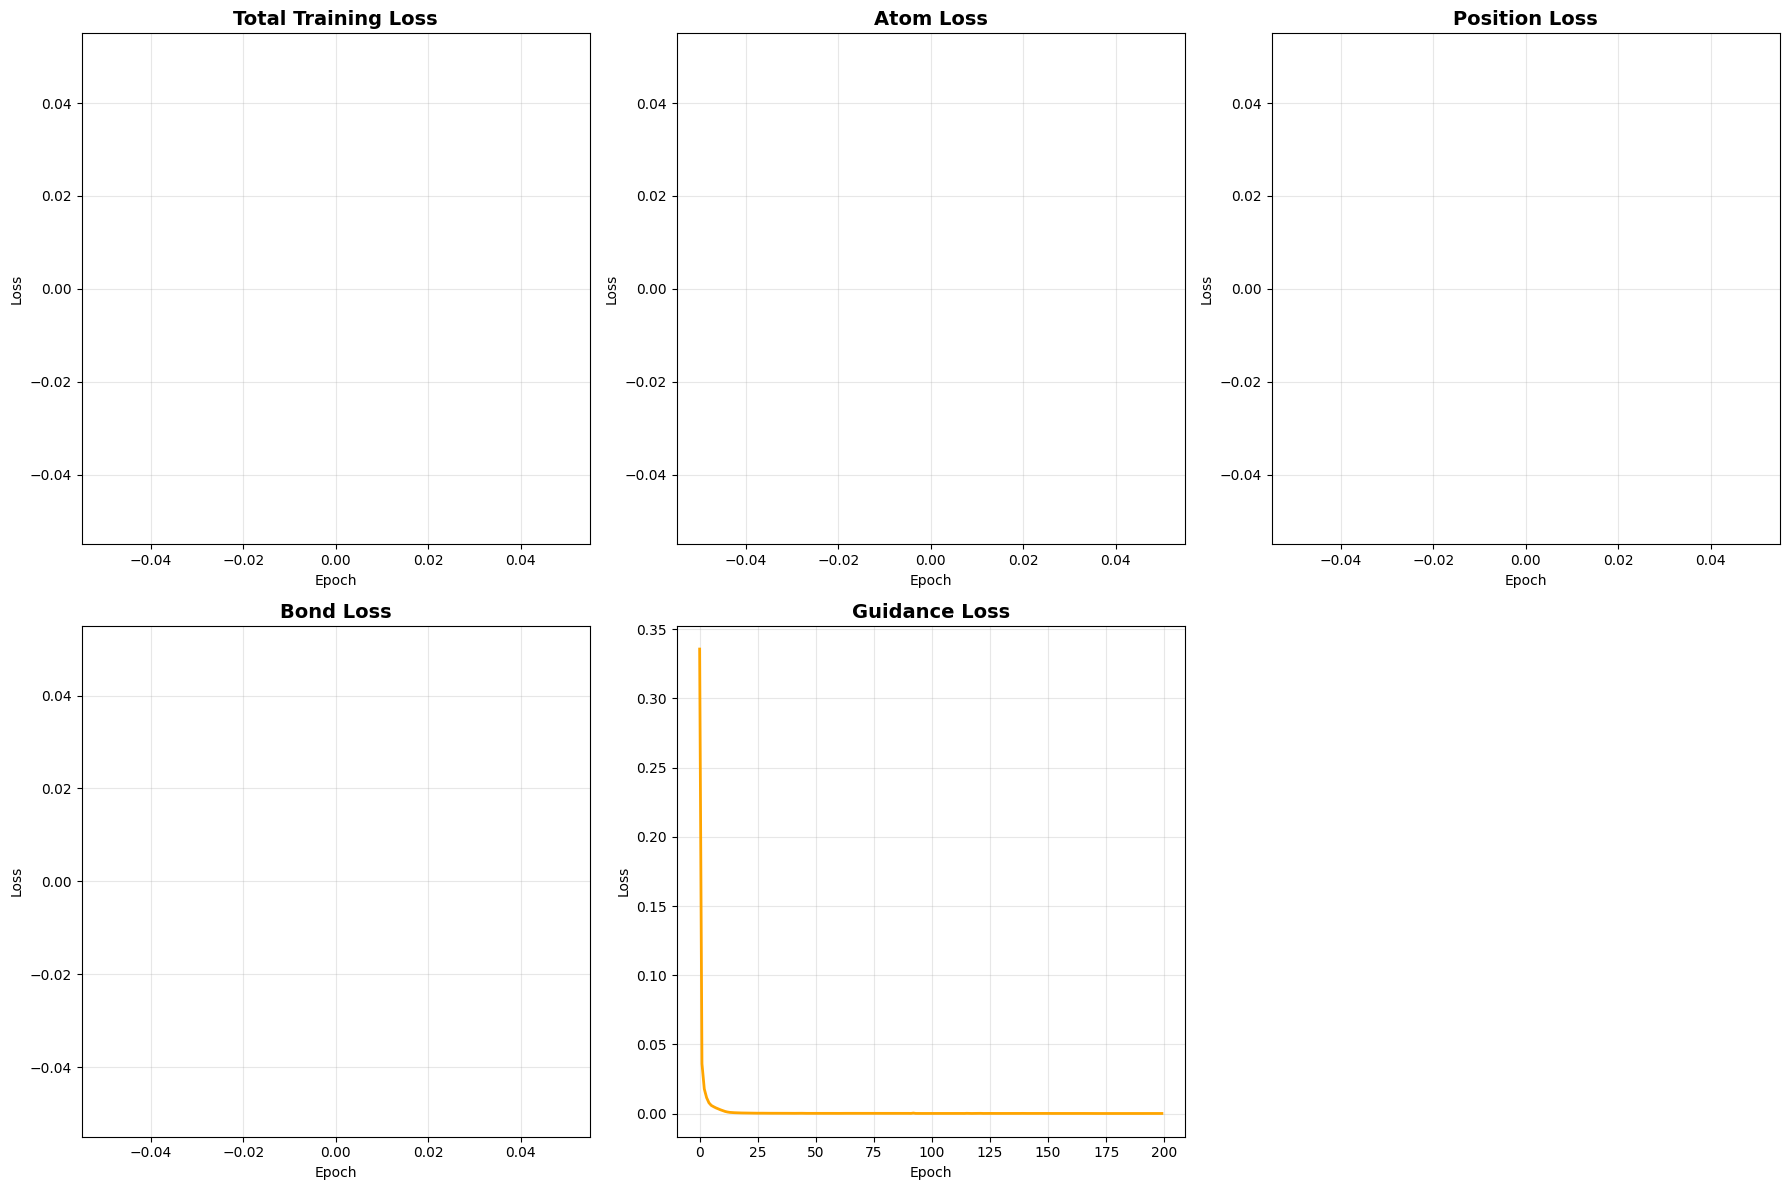


Training Summary:
  Total epochs: 200
  Best total loss: nan (epoch 1)
  Final total loss: nan
  Loss reduction: nan%


In [9]:
print("="*50)
print("STEP 5: TRAINING ANALYSIS")
print("="*50)

# Create comprehensive training visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Total loss
axes[0, 0].plot(losses, 'b-', linewidth=2)
axes[0, 0].set_title('Total Training Loss', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# Individual loss components
loss_titles = ['Atom Loss', 'Position Loss', 'Bond Loss', 'Guidance Loss']
loss_keys = ['atom', 'pos', 'bond', 'guidance']
colors = ['red', 'green', 'blue', 'orange']

for i, (title, key, color) in enumerate(zip(loss_titles, loss_keys, colors)):
    if i < 5:  # Avoid index error
        row, col = divmod(i + 1, 3)
        if row < 2:
            axes[row, col].plot(detailed_losses[key], color=color, linewidth=2)
            axes[row, col].set_title(title, fontsize=14, fontweight='bold')
            axes[row, col].set_xlabel('Epoch')
            axes[row, col].set_ylabel('Loss')
            axes[row, col].grid(True, alpha=0.3)

# Hide unused subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.savefig(results_dir / 'improved_training_losses.png', dpi=300, bbox_inches='tight')
plt.show()

# Print training summary
print("\nTraining Summary:")
print(f"  Total epochs: {len(losses)}")
print(f"  Best total loss: {min(losses):.4f} (epoch {losses.index(min(losses)) + 1})")
print(f"  Final total loss: {losses[-1]:.4f}")
print(f"  Loss reduction: {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")

In [10]:
print("="*50)
print("STEP 6: SAVING CHECKPOINTS")
print("="*50)

# Save main model checkpoint
main_checkpoint_path = results_dir / "moldiff_improved_final.pth"
save_checkpoint(
    filepath=main_checkpoint_path,
    model=model,
    optimizer=optimizer,
    epoch=trainer.epoch,
    loss=np.mean(losses[-10:]),
    metrics={'detailed_losses': detailed_losses}
)

# Save bond predictor separately
bond_checkpoint_path = results_dir / "bond_predictor_final.pth"
torch.save({
    'model_state_dict': bond_predictor.state_dict(),
    'model_config': {
        'atom_dim': info['atom_feature_dim'],
        'pos_dim': config['pos_dim'],
        'hidden_dim': config['hidden_dim']
    }
}, bond_checkpoint_path)

print(f"Checkpoints saved:")
print(f"  Main model: {main_checkpoint_path}")
print(f"  Bond predictor: {bond_checkpoint_path}")

STEP 6: SAVING CHECKPOINTS


INFO:mol_diff_3d.utils.checkpoints:Checkpoint saved to ../results/moldiff_improved/moldiff_improved_final.pth


Checkpoints saved:
  Main model: ../results/moldiff_improved/moldiff_improved_final.pth
  Bond predictor: ../results/moldiff_improved/bond_predictor_final.pth


In [11]:
print("="*50)
print("STEP 7: MOLECULE GENERATION WITH BOND GUIDANCE")
print("="*50)

# Create reverse sampler with bond guidance
p_sampler = ImprovedDDPMPsampler(
    scheduler_params=continuous_scheduler.get_parameters(),
    categorical_diffusion=categorical_diffusion,
    bond_predictor=bond_predictor,      # NEW - bond guidance during sampling
    guidance_scale=1.0
)

print("Starting guided molecule generation...")
print(f"Generating {config['num_molecules_to_generate']} molecules...")

# Generate molecules with bond guidance
generated_mols, generated_smiles, generation_stats = generate_molecules_with_bond_guidance(
    model=model,
    bond_predictor=bond_predictor,
    p_sampler=p_sampler,
    num_molecules=config['num_molecules_to_generate'],
    max_atoms=config['max_atoms'],
    atom_dim=info['atom_feature_dim'],
    bond_dim=info['bond_feature_dim'],
    pos_dim=config['pos_dim'],
    device=device,
    guidance_steps=config['guidance_steps'],
    temperature=config['temperature']
)

print(f"Generation completed!")

INFO:mol_diff_3d.generation.generator:Starting guided molecule generation on cuda...


STEP 7: MOLECULE GENERATION WITH BOND GUIDANCE
Starting guided molecule generation...
Generating 20 molecules...


KeyboardInterrupt: 

In [ ]:
print("="*50)
print("STEP 8: RESULTS ANALYSIS")
print("="*50)

print("GENERATION RESULTS:")
print(f"  Success Rate: {generation_stats['success_rate']:.2%}")
print(f"  Valid Molecules: {generation_stats['successful_generations']}")
print(f"  Failed Generations: {generation_stats['failed_generations']}")
print(f"  Invalid Chemistry: {generation_stats['invalid_chemistry']}")
print(f"  Guidance Applications: {generation_stats['guidance_applications']}")

if len(generated_smiles) > 0:
    print(f"\nGENERATED MOLECULES:")
    for i, smiles in enumerate(generated_smiles[:10]):  # Show first 10
        print(f"  {i+1:2d}: {smiles}")

    if len(generated_smiles) > 10:
        print(f"  ... and {len(generated_smiles) - 10} more")

    # Diversity analysis
    unique_smiles = set(generated_smiles)
    diversity = len(unique_smiles) / len(generated_smiles)
    print(f"\nDIVERSITY ANALYSIS:")
    print(f"  Total molecules: {len(generated_smiles)}")
    print(f"  Unique molecules: {len(unique_smiles)}")
    print(f"  Uniqueness rate: {diversity:.2%}")

    # Molecule size analysis
    mol_sizes = [mol.GetNumAtoms() for mol in generated_mols if mol]
    if mol_sizes:
        print(f"\nSIZE ANALYSIS:")
        print(f"  Average atoms: {np.mean(mol_sizes):.1f}")
        print(f"  Size range: {min(mol_sizes)} - {max(mol_sizes)} atoms")
        print(f"  Standard deviation: {np.std(mol_sizes):.1f}")

    # Chemical properties analysis
    print(f"\nCHEMICAL PROPERTIES:")
    valid_mols = [mol for mol in generated_mols if mol]
    if valid_mols:
        bond_counts = [mol.GetNumBonds() for mol in valid_mols]
        ring_counts = [mol.GetRingInfo().NumRings() for mol in valid_mols]

        print(f"  Average bonds: {np.mean(bond_counts):.1f}")
        print(f"  Average rings: {np.mean(ring_counts):.1f}")

        # Atom type distribution
        atom_symbols = []
        for mol in valid_mols:
            for atom in mol.GetAtoms():
                atom_symbols.append(atom.GetSymbol())

        from collections import Counter
        atom_counts = Counter(atom_symbols)
        print(f"  Atom distribution: {dict(atom_counts.most_common(5))}")

else:
    print("\nWARNING: No valid molecules were generated!")
    print("Consider:")
    print("  - Training for more epochs")
    print("  - Adjusting loss weights (increase bond_loss_weight)")
    print("  - Reducing guidance scale")
    print("  - Using a larger dataset (increase max_samples)")
    print("  - Checking model architecture")

In [ ]:
print("="*50)
print("STEP 9: SAVING RESULTS")
print("="*50)

# Save generated molecules as SDF file
if generated_mols:
    sdf_path = results_dir / "generated_molecules.sdf"
    writer = Chem.SDWriter(str(sdf_path))
    for mol in generated_mols:
        if mol:
            writer.write(mol)
    writer.close()
    print(f"Saved {len(generated_mols)} molecules to: {sdf_path}")

# Save SMILES to text file
if generated_smiles:
    smiles_path = results_dir / "generated_smiles.txt"
    with open(smiles_path, 'w') as f:
        for smiles in generated_smiles:
            f.write(f"{smiles}\n")
    print(f"Saved {len(generated_smiles)} SMILES to: {smiles_path}")

# Save generation statistics
import json
stats_path = results_dir / "generation_stats.json"
with open(stats_path, 'w') as f:
    # Convert any tensors to lists for JSON serialization
    json_stats = {}
    for key, value in generation_stats.items():
        if isinstance(value, torch.Tensor):
            json_stats[key] = value.tolist()
        else:
            json_stats[key] = value
    json.dump(json_stats, f, indent=2)
print(f"Saved generation statistics to: {stats_path}")

# Save training curves data
curves_path = results_dir / "training_curves.npz"
np.savez(curves_path,
         total_losses=np.array(losses),
         atom_losses=np.array(detailed_losses['atom']),
         pos_losses=np.array(detailed_losses['pos']),
         bond_losses=np.array(detailed_losses['bond']),
         guidance_losses=np.array(detailed_losses['guidance'])
)
print(f"Saved training curves to: {curves_path}")

print(f"\nAll results saved to: {results_dir}")

In [ ]:
print("="*50)
print("STEP 10: VISUAL COMPARISON")
print("="*50)

# Create a comparison visualization of some generated molecules
if len(generated_mols) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    from rdkit.Chem import Draw
    from rdkit.Chem.Draw import rdMolDraw2D
    import io
    from PIL import Image

    for i in range(min(4, len(generated_mols))):
        mol = generated_mols[i]
        if mol:
            # Create 2D depiction
            img = Draw.MolToImage(mol, size=(300, 300))

            # Convert to numpy array for matplotlib
            img_array = np.array(img)

            axes[i].imshow(img_array)
            axes[i].set_title(f"Generated Molecule {i+1}\n{generated_smiles[i][:30]}...")
            axes[i].axis('off')

    plt.tight_layout()
    plt.savefig(results_dir / 'generated_molecules_visual.png', dpi=300, bbox_inches='tight')
    plt.show()

print("Tutorial completed successfully!")
print("\nNext steps:")
print("1. Experiment with different hyperparameters")
print("2. Try larger datasets for better results")
print("3. Implement additional guidance mechanisms")
print("4. Add property-based generation objectives")